In [188]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os 
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Designing the model

In [7]:
train_dir = '../../src/data/train'
validation_dir = '../../src/data/val'
test_dir = '../../src/data/test'

In [178]:
# Your code here; design and compile the model
dagenerator = ImageDataGenerator(rescale=1./255)
target_size = (64, 64)
batch_size = 10




train_generator = dagenerator.flow_from_directory(
        train_dir,
        target_size= target_size, 
        batch_size = batch_size, 
        color_mode="rgb")

val_generator = dagenerator.flow_from_directory(
        validation_dir,
        target_size= target_size, 
        batch_size = batch_size,
        color_mode="rgb", shuffle=False )

test_generator = dagenerator.flow_from_directory(
        test_dir,
        target_size= target_size, 
        batch_size = num_of_test_samples, #All images in test set
        class_mode=None, 
        color_mode="rgb", shuffle=False)

Found 4101 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# First simple model

In [179]:
# Simple model
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        epochs=5)

Epoch 1/5
411/411 [==============================] - 5s 11ms/step - loss: 0.9018 - acc: 0.5767 - val_loss: 0.8482 - val_acc: 0.5926
Epoch 2/5
411/411 [==============================] - 4s 9ms/step - loss: 0.6189 - acc: 0.7432 - val_loss: 0.5934 - val_acc: 0.7690
Epoch 3/5
411/411 [==============================] - 4s 10ms/step - loss: 0.4395 - acc: 0.8303 - val_loss: 0.4297 - val_acc: 0.8635
Epoch 4/5
411/411 [==============================] - 5s 12ms/step - loss: 0.3258 - acc: 0.8864 - val_loss: 0.3658 - val_acc: 0.8694
Epoch 5/5
411/411 [==============================] - 5s 12ms/step - loss: 0.2256 - acc: 0.9320 - val_loss: 0.3923 - val_acc: 0.8285


# Results of model

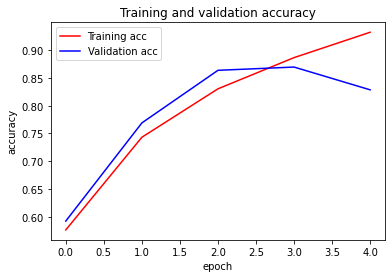

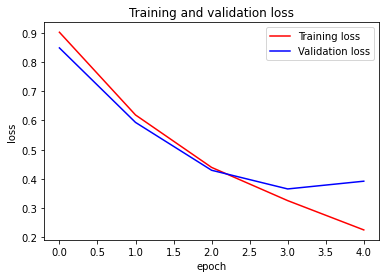

In [180]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.99      0.53      0.69       144
    Moderate       1.00      0.91      0.95        11
        None       0.98      0.79      0.88       512
   Very Mild       0.68      0.99      0.81       359

    accuracy                           0.83      1026
   macro avg       0.91      0.81      0.83      1026
weighted avg       0.88      0.83      0.83      1026

------------------------Confusion Matrix---------------------------


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

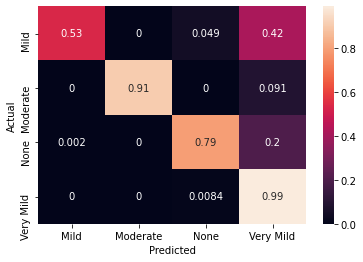

In [224]:
#Confution Matrix and Classification Report
num_of_val_samples = len(glob.glob('../../src/data/val/*/*.jpg'))

Y_pred = model.predict_generator(val_generator, num_of_val_samples// batch_size+1) # so it lines up with the batches
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Mild','Moderate','None','Very Mild']
print('-----------------------Classification Report-------------------')
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
print('------------------------Confusion Matrix---------------------------')

conf = confusion_matrix(val_generator.classes, y_pred, normalize='true')
ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
ax.set(xlabel='Predicted', ylabel='Actual')

So its predicting Mild Alzeimers as very mild quite often and its predicting no alzheimers as very mild alzeimers

# Looking at the Activation Layers

In [114]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [115]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9610)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 38444     
Total params: 38,724
Trainable params: 38,724
Non-trainable params: 0
_________________________________________________________________


(1, 62, 62, 10)


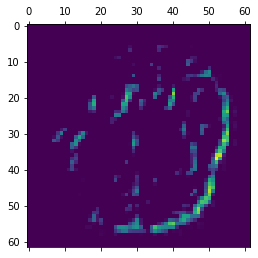

In [124]:
img_path = '../../src/data/train/NonDemented/nondem100.jpg'


img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]  #The first activation layer 
print(first_layer_activation.shape)

# We slice the 9th channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis') # There are 10 different channels because our input was 10 for our first layer
plt.show()

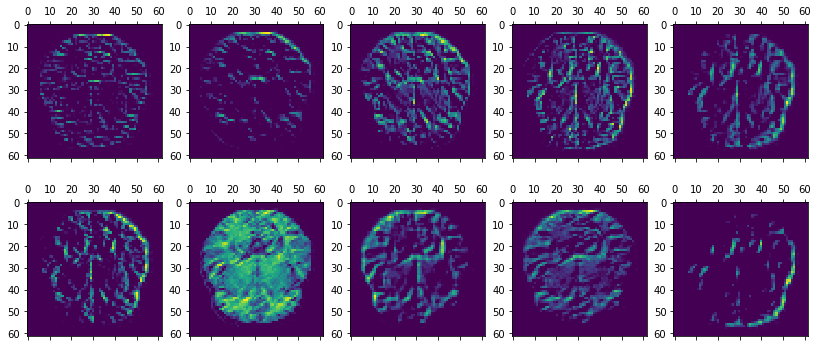

In [123]:
# All the different channels of the first imput layer. 
fig, axes = plt.subplots(2, 5, figsize=(14,6))
for i in range(10):
    row = i//5
    column = i%5
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

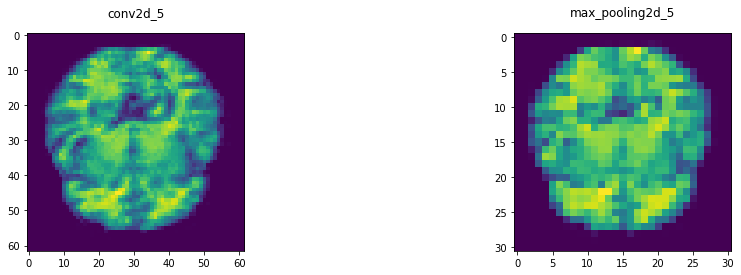

In [108]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

layer_names = []
for layer in model.layers[:2]:
    layer_names.append(layer.name)

for i in range(2):
    column = i%4
    ax = axes[column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 2], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])